# **Workshop VII** <br/> *Bayesian inference and decision trees*

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from decimal import Decimal

import ID3  # decision tree module

---

## **1.** Bayesian Basics

This first exercise is meant as an introduction to the Bayesian framework. In particular, we will simulate a dataset of disease contamination. By simulating the dataset, we know the "true" parameter values and we can thus examine how accurate our inferences are. To get started, lets set up the simulation parameters.

In [27]:
# simulate a population of 100,000 people:
population = 100_000
prevalence = 0.01   # disease prevalence
sensitivity = 0.95  # true positive rate
specificity = 0.90  # true negative rate

# infectious status (1 = infected, 0 = not infected):
population_status = np.random.choice([1, 0], size=population, p=[prevalence, 1-prevalence])

# assign some fictitious test results to the population, based on our sensitivity and specificity:
test_results = np.zeros(population)
for i in range(population):
    if population_status[i] == 1:
        test_results[i] = np.random.choice([1, 0], p=[sensitivity, 1-sensitivity])
    else:
        test_results[i] = np.random.choice([1, 0], p=[1-specificity, specificity])


In [28]:
# create a dataframe to store the population data:
df = pd.DataFrame({'status': population_status, 'test_result': test_results})

Now, assuming that we have access to both the test results and the true results (the "status"), try to extract the Baysian probabilities from our simulated data, to find out posterior probability of being infected, given a positive test result. 

In [29]:
# calculate the Bayesian probabilities:
prior_probability = df['status'].mean()
likelihood = df[df['status'] == 1]['test_result'].mean()
probability_testing_positive = df['test_result'].mean()

print('Prior probability of infection:', prior_probability)
print('Likelihood of testing positive given infection:', likelihood)
print('Probability of testing positive:', probability_testing_positive)

Prior probability of infection: 0.01007
Likelihood of testing positive given infection: 0.9414101290963257
Probability of testing positive: 0.10845


In [30]:
# Bayesian inference of Pr(status=1 | test=1)
def bayes_theorem(prior, likelihood, evidence):
    return (prior * likelihood) / evidence

pr_infected_given_positive = bayes_theorem(prior_probability, likelihood, probability_testing_positive)

print('Pr(status=1 | test=1) = ', pr_infected_given_positive) # = (Pr(test=1 | status=1) * Pr(status=1)) / Pr(test=1)

Pr(status=1 | test=1) =  0.08741355463347164


Interpret your finding.

If sensitivity is increased to 0.999, the specificity remains as original, what is the value of Pr(status=1 | test=1)?

If specificity is increased to 0.999, the sensitivity remains as original, what is the value of Pr(status=1 | test=1)?

Interprete your finding.

(After this question finished, generate a sample with the original value, i.e. sensitivity = 0.95, specificity = 0.90, for the next question.)

---

## **2.** Dealing with Uncertainty

Of course, we are never able to take a peak into the true population parameters in real life. There will always be uncertainty. So far you have tried to quantify this uncertainty using frequentist techniques (i.e. maximum likelihood estimations, etc). Today you will quantify your uncertainty differently, using Bayesian statistics.

In the following, you will try to use Bayesian inference to go from data to results.

Now suppose we want to estimate the average weight of fish in a fishery farm. The real average weight of the fish is 2 kg. but we do not know this value beforehand. After a number of catches, we get data on the weight of a batch of fish. We know that the weights of the detected fish obeys a normal distribution around the mean value. How can we obtain the actual average weight of the fish from this data?

Let's start by adding some small data that obeys normal distribution. The mean is set to be 2 and the standard deviation is 1.

The Data generated from the following code:

#np.random.seed = 39

#sample_data = np.random.normal(2, 1, 30)

In [64]:
sample_data = np.array([ 1.64350291,  0.87752135,  3.05569158,  1.48274427,  1.4059861 ,
        3.93554187,  0.53890017,  2.12058382,  0.54360397,  2.25308647,
        2.71833633,  2.11059019,  0.90982909,  3.10162428,  2.99375448,
        1.9048221 ,  2.25047556,  2.60237373,  1.59678977,  2.00217239,
        1.3469326 ,  1.05712171,  0.32794892,  3.36094034, -0.42828078,
        1.27685994,  2.84693071,  3.21779923,  0.15080283,  2.29198599])

Now, because we cannot obtain the true value anymore, we set up a *prior distribution* to represent our uncertainty. 

Set up 4 priors to compare their effect on the posterior distribution later. Use the population value obtained in the previous part (i.e. approximately 0.0.1).

In [65]:
x_range = np.linspace(1,3,100)

# Prior 1: uncertain
prior1 = beta.pdf(x_range/3.0, 1, 1)/3.0

# Prior 2: somewhat uncertain
prior2 = beta.pdf(x_range/3.0, 1, 3)/3.0

# Prior 3: somewhat certain
prior3 = beta.pdf(x_range/3.0, 5, 3)/3.0

# Prior 4: certain
prior4 = beta.pdf(x_range/3.0, 30, 15)/3.0

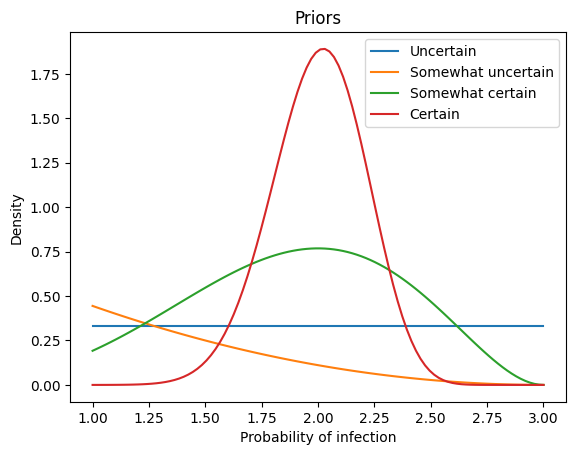

In [66]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    plt.plot(x_range, prior, label=title)

plt.xlabel('Probability of infection')
plt.ylabel('Density')
plt.title('Priors')
plt.legend()

Equiped with the prior distributions, we now form the likelihood.

In [67]:
# multiply log elements together
def multiply_elements(array):
    return np.log(array).sum()

# computing exponential function and normalization for large value
def largeExpNormalize(x_range,loglikelihoodlist):
    declikelihood = [Decimal(k).exp() for k in loglikelihoodlist]
    
    surface = Decimal(0)
    for i in range(1,len(x_range)):
        surface += Decimal(x_range[i]-x_range[i-1])*declikelihood[i]        
    
    mlh = [float(k/surface) for k in declikelihood]
    return mlh

# Gaussian pdf
def loglikelihood_function_normal(data,miu,sigma):
    return multiply_elements(norm.pdf(data, miu, sigma))

loglikelihoodlist = []
sigma = np.std(sample_data,ddof=1)
for miu in x_range:
    p = loglikelihood_function_normal(sample_data,miu,sigma)
    loglikelihoodlist.append(p)

mlh = largeExpNormalize(x_range,loglikelihoodlist)

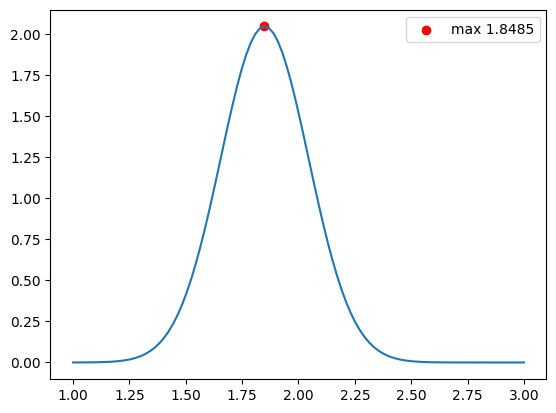

In [68]:
plt.plot(x_range, mlh)
plt.scatter(x_range[np.argmax(mlh)], mlh[np.argmax(mlh)], color='red',label="max %.4f"%(x_range[np.argmax(mlh)]))
plt.legend()

Compute the posterior with prior 1-4.

In [36]:
def getSurface(x,y):
    surface = 0
    for i in range(1,len(x)):
        surface += (x[i]-x[i-1])*y[i]        
    return surface 

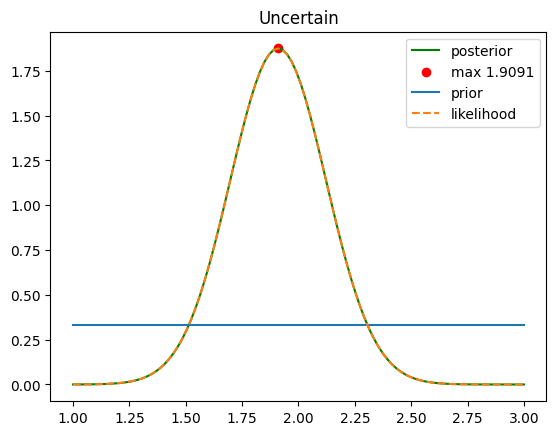

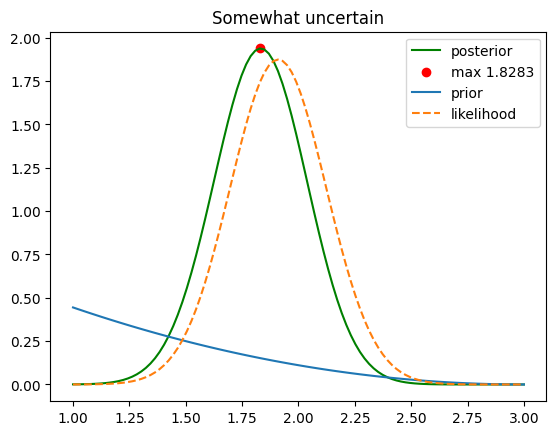

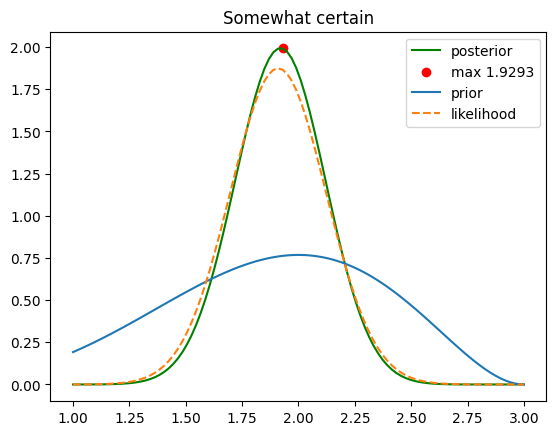

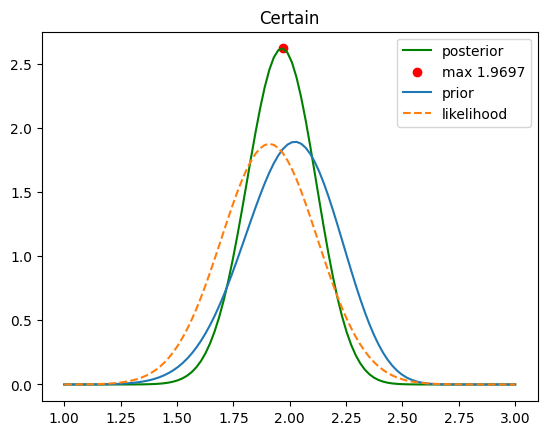

In [37]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    
    posterior = mlh * prior
    posterior /= getSurface(x_range, posterior)  # normalize

    plt.plot(x_range, posterior, 'g', label="posterior")
    plt.scatter(x_range[np.argmax(posterior)], posterior[np.argmax(posterior)], color='red',label="max %.4f"%(x_range[np.argmax(posterior)]))
    
    plt.plot(x_range, prior, label="prior")
    plt.plot(x_range, mlh, linestyle='--', label="likelihood")

    plt.legend()
    #plt.xlim(1.75,2.25)
    plt.title(title)
    plt.show()


Interpret the above plots.

---

## 3. Decision Trees: ID3

In this section, you will use the provided `ID3.py` algorithm implementation to build and interpret a decision tree classifier. Apply this classifier to a real-world dataset, perform some predictions, and then analyze the decision tree's structure.

Information on the variables in this dataset:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type:
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved   
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy        
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
    - Value 0: < 50% diameter narrowing, which is no disease.
    - Value more than 0: > 50% diameter narrowing (in any major vessel), which indicates disease.

Load the "Heart Disease UCI" dataset & remove missing values.

In [38]:
# import data & add column names
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]
df = pd.read_csv('processed.cleveland.data', names=column_names, header=None)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [39]:
# drop missing values
df.replace('?', np.nan, inplace=True)  # missing entries are marked with '?'
df.dropna(inplace=True)

Convert the continuous attributes into categorical ones.

In [40]:
# Binning 'age' into categories
bins_age = [0, 30, 40, 50, 60, 70, 120]
labels_age = ['below 30', '30-39', '40-49', '50-59', '60-69', 'above 70']
df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

# Binning 'trestbps' (resting blood pressure) into categories
bins_trestbps = [0, 120, 140, 160, 180, 200]
labels_trestbps = ['below 120', '121-140', '141-160', '161-180', 'above 180']
df['trestbps'] = pd.cut(df['trestbps'], bins=bins_trestbps, labels=labels_trestbps, include_lowest=True)

# Binning 'chol' (serum cholesterol) into categories
bins_chol = [0, 200, 239, 280, 500]
labels_chol = ['Desirable', 'Borderline', 'High', 'Very high']
df['chol'] = pd.cut(df['chol'], bins=bins_chol, labels=labels_chol, include_lowest=True)

# Binning 'thalach' (maximum heart rate achieved) into categories
bins_thalach = [0, 100, 150, 200, 300]
labels_thalach = ['below 100', '100-150', '151-200', 'above 200']
df['thalach'] = pd.cut(df['thalach'], bins=bins_thalach, labels=labels_thalach, include_lowest=True)

# Binning 'oldpeak' (ST depression induced by exercise relative to rest) into categories
bins_oldpeak = [0, 1, 2, 3, 5]
labels_oldpeak = ['below 1', '1-2', '2-3', 'above 3']
df['oldpeak'] = pd.cut(df['oldpeak'], bins=bins_oldpeak, labels=labels_oldpeak, include_lowest=True)

# Giving cp (chest pain type) more descriptive names
cp_replacements = {1.0: 'typical angina', 
                   2.0: 'atypical angina', 
                   3.0: 'non-anginal pain', 
                   4.0: 'asymptomatic'}
df['cp'] = df['cp'].replace(cp_replacements)

# Giving sex more descriptive names
sex_replacement = {0: 'female',
                      1: 'male'}
df['sex'] = df['sex'].replace(sex_replacement)

# Giving slope (the slope of the peak exercise ST segment) more descriptive names
slope_replacements = {1.0: 'upsloping', 
                     2.0: 'flat', 
                     3.0: 'downsloping'}
df['slope'] = df['slope'].replace(slope_replacements)

# Giving thal (thalium stress test result) more descriptive names
thal_replacements = {3.0: 'normal', 
                    6.0: 'fixed defect', 
                    7.0: 'reversable defect'}
df['thal'] = df['thal'].replace(thal_replacements)

# Giving num (diagnosis of heart disease) more descriptive names
num_replacements = {0: 'no disease', 
                    1: 'disease',
                    2: 'disease',
                    3: 'disease',
                    4: 'disease',
                    5: 'disease'}
df['num'] = df['num'].replace(num_replacements)

# Turn the rest into string
df = df.astype(str)

# show
print([type(df.iloc[0,i]) for i in range(len(df.columns))])
df.head()

[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,60-69,male,typical angina,141-160,Borderline,1.0,2.0,100-150,0.0,2-3,downsloping,0.0,6.0,no disease
1,60-69,male,asymptomatic,141-160,Very high,0.0,2.0,100-150,1.0,1-2,flat,3.0,3.0,disease
2,60-69,male,asymptomatic,below 120,Borderline,0.0,2.0,100-150,1.0,2-3,flat,2.0,7.0,disease
3,30-39,male,non-anginal pain,121-140,High,0.0,0.0,151-200,0.0,above 3,downsloping,0.0,3.0,no disease
4,40-49,female,atypical angina,121-140,Borderline,0.0,2.0,151-200,0.0,1-2,upsloping,0.0,3.0,no disease


Split the dataset into training and test sets.

In [41]:
# Rename the 'num' column to 'class' for compatibility with the ID3 algorithm
df_renamed = df.rename(columns={'num': 'class'})

# Split the DataFrame into features and target
X = df_renamed.drop('class', axis=1)  # Drop the target
y = df_renamed['class']  # Target column

# Convert the target back into a DataFrame and name the column 'class' for compatibility
y = pd.DataFrame(y, columns=['class'])

# Combine X and y for the ID3 algorithm
data_for_id3 = pd.concat([X, y], axis=1)

# Split the dataset into training and test sets
data_train, data_test = train_test_split(data_for_id3, test_size=0.2, random_state=42)

Now, using the provided ID3 algorithm, construct a decision tree using the training set.

In [42]:
features = list(data_train.columns[:-1])

# Construct the decision tree
decision_tree = ID3.ID3(data_train, data_train, features, 'class')

In [43]:
# Print the tree to get an idea of its structure
ID3.print_tree(decision_tree)

ca
|--- 0.0
|   |--- thal
|   |   |--- 3.0
|   |   |   |--- age
|   |   |   |   |--- 30-39
|   |   |   |   |   |--- no disease
|   |   |   |   |--- 40-49
|   |   |   |   |   |--- oldpeak
|   |   |   |   |   |   |--- 1-2
|   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |--- 2-3
|   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |--- above 3
|   |   |   |   |   |   |   |--- disease
|   |   |   |   |   |   |--- below 1
|   |   |   |   |   |   |   |--- cp
|   |   |   |   |   |   |   |   |--- asymptomatic
|   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |--- atypical angina
|   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |--- non-anginal pain
|   |   |   |   |   |   |   |   |   |--- trestbps
|   |   |   |   |   |   |   |   |   |   |--- 121-140
|   |   |   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |   |   |--- below 120
|   |   |   |   |   |   |   |

Implement a code to use the constructed decision tree to make predictions on the test set.

In [44]:
# The 'class' column should not be included in the features of the test set
test_features = data_test.drop('class', axis=1)

# Use the new prediction function to get predictions for the test set
# default value is used when no result is obtained
predictions = ID3.predictDataset(test_features, decision_tree, default="no disease")

# Compare the predictions with the actual values
actual_values = data_test['class'].tolist()
comparison = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions})

print(comparison)

        Actual   Predicted
0   no disease  no disease
1      disease     disease
2   no disease  no disease
3      disease     disease
4   no disease  no disease
5   no disease  no disease
6   no disease  no disease
7   no disease  no disease
8      disease     disease
9   no disease  no disease
10     disease  no disease
11  no disease  no disease
12  no disease  no disease
13  no disease     disease
14  no disease  no disease
15  no disease  no disease
16  no disease     disease
17  no disease     disease
18     disease     disease
19  no disease  no disease
20     disease     disease
21     disease     disease
22     disease     disease
23  no disease  no disease
24     disease     disease
25  no disease  no disease
26     disease     disease
27     disease     disease
28  no disease  no disease
29  no disease  no disease
30  no disease  no disease
31  no disease  no disease
32     disease     disease
33  no disease  no disease
34  no disease  no disease
35  no disease  no disease
3

Accuracy: 0.8000


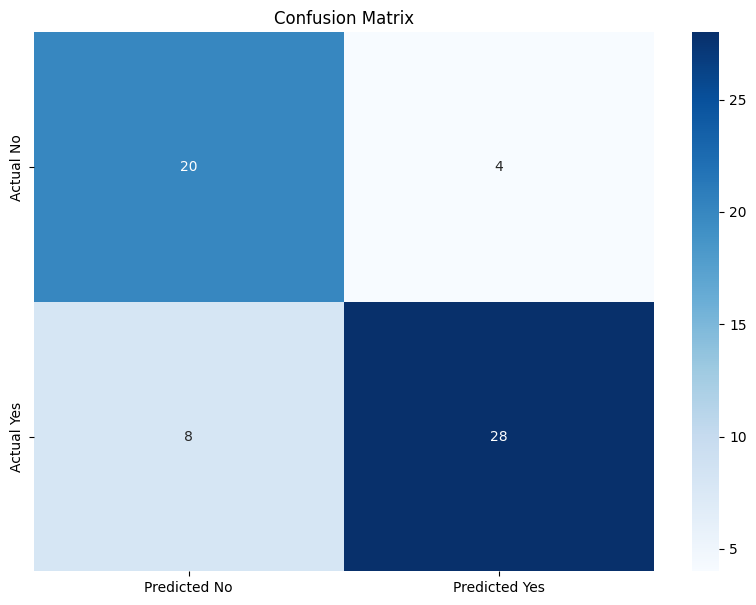

In [45]:
# Lets visualize the accuracy!
accuracy = accuracy_score(actual_values, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_values, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
plt.show()

Finally, interpret your decision tree:

In [46]:
ID3.print_tree(decision_tree)

ca
|--- 0.0
|   |--- thal
|   |   |--- 3.0
|   |   |   |--- age
|   |   |   |   |--- 30-39
|   |   |   |   |   |--- no disease
|   |   |   |   |--- 40-49
|   |   |   |   |   |--- oldpeak
|   |   |   |   |   |   |--- 1-2
|   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |--- 2-3
|   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |--- above 3
|   |   |   |   |   |   |   |--- disease
|   |   |   |   |   |   |--- below 1
|   |   |   |   |   |   |   |--- cp
|   |   |   |   |   |   |   |   |--- asymptomatic
|   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |--- atypical angina
|   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |--- non-anginal pain
|   |   |   |   |   |   |   |   |   |--- trestbps
|   |   |   |   |   |   |   |   |   |   |--- 121-140
|   |   |   |   |   |   |   |   |   |   |   |--- no disease
|   |   |   |   |   |   |   |   |   |   |--- below 120
|   |   |   |   |   |   |   |

The attribute at the very beginning (top) of the printout is the root node. This is considered the most important attribute for making predictions because it provides the highest information gain at the first decision point. Each branch from a node represents a possible value of the attribute. The branches lead either to another decision node (indicating another test on an attribute) or to a leaf node. The leaf nodes indicate the predicted outcome (presence or absence of heart disease in this context) based on the path (the decisions) taken from the root to that leaf. Finally, each path from the root to a leaf represents a decision rule derived from the tree, indicating a combination of attribute values that lead to a specific prediction.

In general, the higher on top an attribute is, the more important it is in the predictions. Furthermore, the more frequently throughout the tree it appears, the more significant it is.

---

## **4.** Decision Trees: CART

In [47]:
# Reload the data
df = pd.read_csv('processed.cleveland.data', names=column_names, header=None)
df.replace('?', np.nan, inplace=True)  # missing entries are marked with '?'
df.dropna(inplace=True)

X = df.drop('num', axis=1)  # features
y = df['num']  # target

# Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print([type(X_train.iloc[0,i]) for i in range(len(X_train.columns))])

[<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'str'>, <class 'str'>]


Because CART allows for the use of continuous variables, we do not need to do any binning this time.

In [48]:
# Create a DecisionTreeClassifier object
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
cart_model.fit(X_train, y_train);

Now let's make some predictions on the test set to evaluate performance:

Accuracy: 0.4833


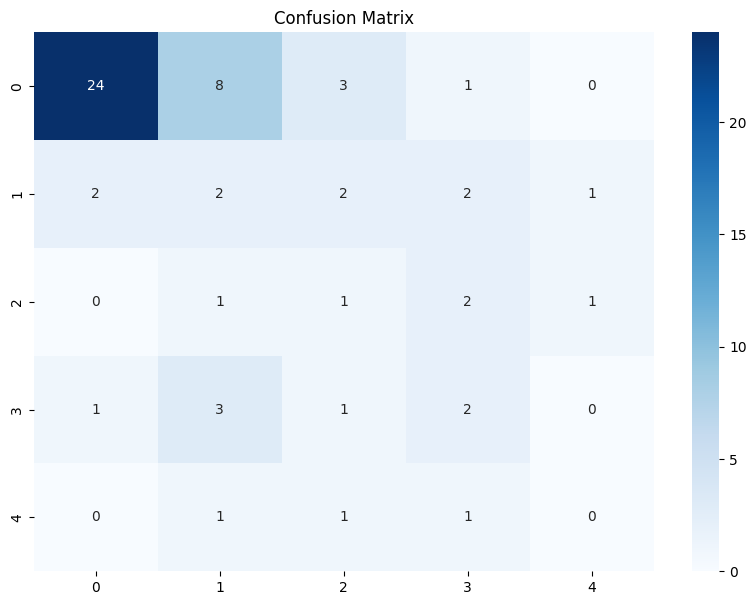

In [49]:
# Making predictions
predictions = cart_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.show()

Finally, we visualize the decision tree:

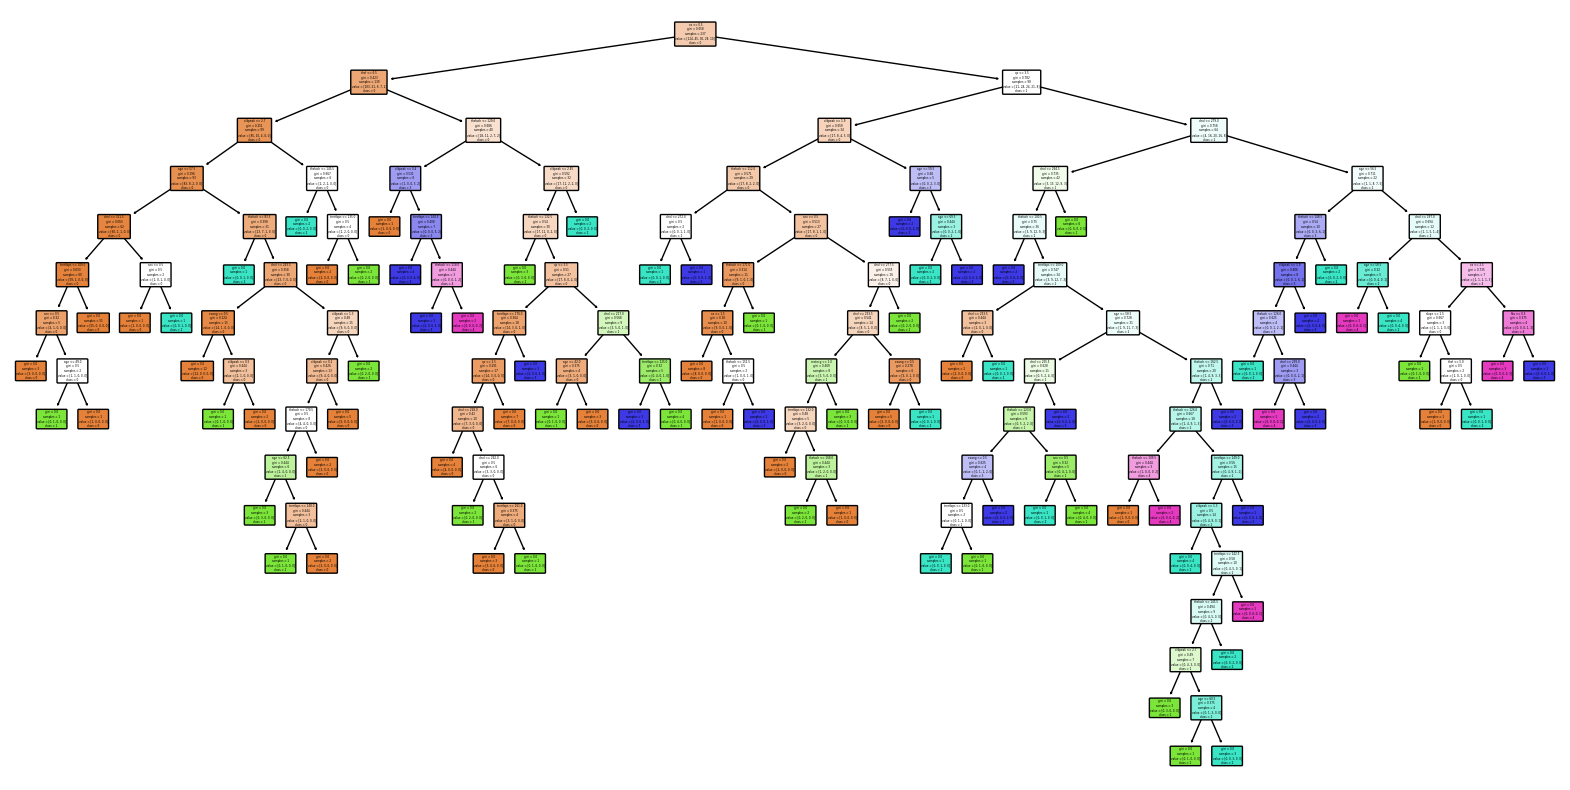

In [50]:
plt.figure(figsize=(20,10))
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          class_names=['0', '1', '2', '3', '4'],  # Update class names as appropriate
          feature_names=list(X_train.columns))       # Ensure X_train.columns is accessible
plt.show()

Please interpret the results, try to answer the following:

- How well did both models predict heart disease presence?
- Describe the model's performance in terms of false positives, false negatives, true positives, and true negatives.
- Analyze the tree to determine the most important features and decision paths leading to heart disease prediction.